# Lab - 8

Importing the required libraries and checking for the Python version

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import cv2

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Loading both training and testing dataset:

In [2]:
CW_DATASET_PATH = "CW_dataset"

def load_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")
    x_test_all_path = os.path.join(dataset_path, "x_test_all.csv")
    y_test_all_path = os.path.join(dataset_path, "y_test_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)
    x_test_all = pd.read_csv(x_test_all_path)
    y_test_all = pd.read_csv(y_test_all_path)

    return x_train_all, y_train_all,x_test_all,y_test_all

In [3]:
x_train, y_train,x_test, y_test = load_data()

In [4]:
x_train.shape

(9690, 2304)

In [5]:
y_train.shape

(9690, 1)

In [6]:
x_test.shape

(3090, 2304)

In [7]:
y_train = y_train.values.ravel()

# Using a Decision Classifier (on the training dataset)

In [8]:
from sklearn.tree import DecisionTreeClassifier,plot_tree

tree_clf = DecisionTreeClassifier(max_depth=10, random_state=42)
tree_clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

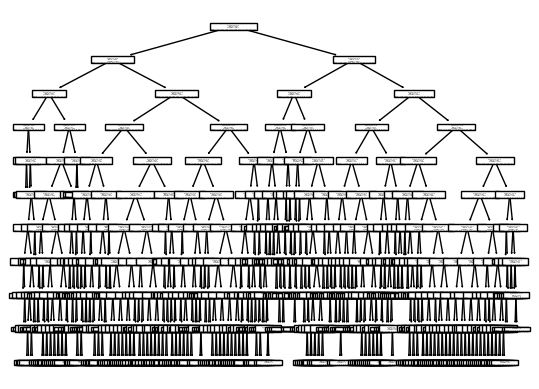

In [9]:
plot_tree(tree_clf);

## Evaluation Metrics for training dataset

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score

y_train_pred = tree_clf.predict(x_train)
accuracy_training = accuracy_score(y_train, y_train_pred)
# confusion_matrix_training = confusion_matrix(y_train, y_train_pred)
classification_report_training = classification_report(y_train, y_train_pred, zero_division=1)


# roc_auc = roc_auc_score(y_train, y_train_proba)
print("Accuracy on the training set:", accuracy_training)
# print("Confusion Matrix on the training set:\n", confusion_matrix_training)
print("Classification Report on the training set:\n", classification_report_training)

#print("roc_auc:", roc_auc)

Accuracy on the training set: 0.904437564499484
Classification Report on the training set:
               precision    recall  f1-score   support

           0       0.95      0.70      0.81       210
           1       0.89      0.91      0.90      2220
           2       0.86      0.92      0.89      2250
           3       0.94      0.92      0.93      1410
           4       0.93      0.93      0.93      1980
           5       0.84      0.75      0.79       210
           6       0.95      0.87      0.91       360
           7       0.91      0.76      0.83       240
           8       0.98      0.91      0.94       540
           9       0.85      0.89      0.87       270

    accuracy                           0.90      9690
   macro avg       0.91      0.86      0.88      9690
weighted avg       0.91      0.90      0.90      9690



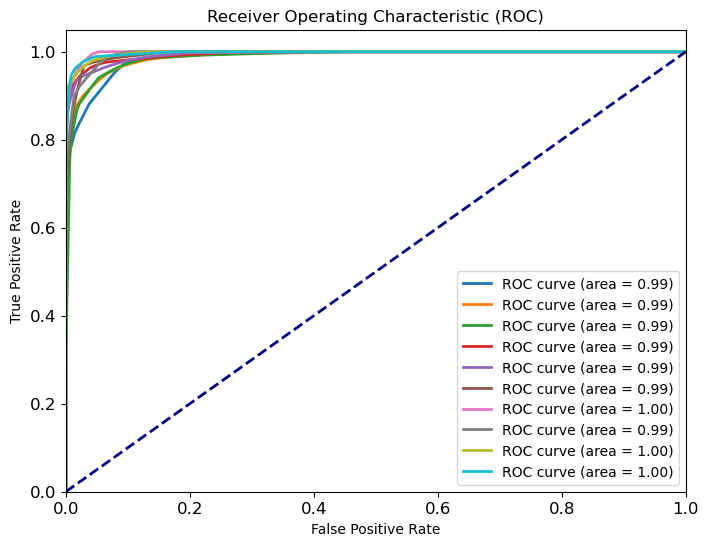

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

probabilities_dt_train = tree_clf.predict_proba(x_train)
roc_auc_scores_dt_train = []

plt.figure(figsize=(8, 6))
unique_labels_dt_train = np.unique(y_train)

for i in range(len(unique_labels_dt_train)):
    fpr_dt_train, tpr_dt_train, _ = roc_curve((y_train == unique_labels_dt_train[i]).astype(int), probabilities_dt_train[:, i])
    roc_auc_dt_train = auc(fpr_dt_train, tpr_dt_train)
    roc_auc_scores_dt_train.append(roc_auc_dt_train)
    plt.plot(fpr_dt_train, tpr_dt_train, lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_dt_train))
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### Cross Validation results on training dataset

In [12]:
cross_val_scores = cross_val_score(tree_clf, x_train, y_train, cv=10, scoring='accuracy')
print("Accuracy using 10-fold cross-validation on train set:", cross_val_scores.mean())


Accuracy using 10-fold cross-validation on train set: 0.663983488132095


# Finding Optimal Hyperparameters Using Randomized Search 

In [13]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats

# Define the parameter distributions to sample from
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': scipy.stats.randint(1, 100),
    'min_samples_split': scipy.stats.randint(2, 20),
    'min_samples_leaf': scipy.stats.randint(1, 10)
}

# Create the Decision Tree classifier
tree_clf = DecisionTreeClassifier(random_state=42)

# Perform Random Search with cross-validation
random_search = RandomizedSearchCV(tree_clf, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Fit the random search to your data
random_search.fit(x_train, y_train)

# Get the best hyperparameters and model
best_params = random_search.best_params_
best_tree_clf = random_search.best_estimator_
print("Best Parameters:", best_params)

Best Parameters: {'criterion': 'entropy', 'max_depth': 74, 'min_samples_leaf': 4, 'min_samples_split': 15}


# Tree 1 
## Classifier with best working parameters

In [14]:
best_tree_clf

DecisionTreeClassifier(criterion='entropy', max_depth=74, min_samples_leaf=4,
                       min_samples_split=15, random_state=42)

### Accuracy for training dataset

In [15]:
y_tr = best_tree_clf.predict(x_train)

acc = accuracy_score(y_train, y_tr)
print("Accuracy on training set", acc)

Accuracy on training set 0.9463364293085655


### Accuracy for testing dataset 

In [16]:

y_pred = best_tree_clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy on the test set:", accuracy)


Accuracy on the test set: 0.7236245954692556


# Tree 2 
## Moving 30% of training instances into testing dataset

In [17]:
def split_dataset(X_train, Y_train, split_ratio):
    x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=split_ratio, random_state=42)

    return x_train, y_train, x_test, y_test

In [18]:
x_train_3, y_train_3, x_test_3, y_test_3 = split_dataset(x_train, y_train, 0.3)

y_test = y_test.values.ravel()

new_x_test_30 = np.concatenate([x_test, x_test_3], axis=0)
new_y_test_30 = np.concatenate([y_test, y_test_3], axis=0)

# Verify the shapes of the concatenated sets
print("Shape of Original Test Set:", x_test.shape)
print("Shape of New 30% Test Set:", x_test_3.shape)
print("Shape of Concatenated Test Set:", new_x_test_30.shape)

Shape of Original Test Set: (3090, 2304)
Shape of New 30% Test Set: (2907, 2304)
Shape of Concatenated Test Set: (5997, 2304)


In [19]:
classifier_tree_clf_30= DecisionTreeClassifier(criterion='entropy', max_depth=74, min_samples_leaf=4,
                       min_samples_split=15, random_state=42)
classifier_tree_clf_30.fit(x_train_3, y_train_3)


DecisionTreeClassifier(criterion='entropy', max_depth=74, min_samples_leaf=4,
                       min_samples_split=15, random_state=42)

### Accuracy for new training dataset

In [20]:
y_predict_train30 = classifier_tree_clf_30.predict(x_train_3)

accuracy_30 = accuracy_score(y_train_3, y_predict_train30)
report_30 = classification_report(y_train_3, y_predict_train30, zero_division=1)

print(f'Accuracy: {accuracy_30}')
print(f'Classification Report:\n {report_30}')

Accuracy: 0.9408816158042165
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       135
           1       0.93      0.97      0.95      1555
           2       0.94      0.96      0.95      1572
           3       0.98      0.93      0.95       984
           4       0.97      0.96      0.96      1393
           5       0.78      0.88      0.82       139
           6       0.94      0.87      0.90       260
           7       0.92      0.87      0.89       175
           8       0.94      0.93      0.94       382
           9       0.90      0.85      0.87       188

    accuracy                           0.94      6783
   macro avg       0.91      0.91      0.91      6783
weighted avg       0.94      0.94      0.94      6783



### Accuracy for new testing dataset

In [21]:
y_predict_test30 = classifier_tree_clf_30.predict(new_x_test_30)

accuracy_test30 = accuracy_score(new_y_test_30, y_predict_test30)
report_test30 = classification_report(new_y_test_30, y_predict_test30, zero_division=1)


print(f'Accuracy: {accuracy_test30}')
print(f'Classification Report:\n {report_test30}')

Accuracy: 0.7707186926796732
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.55      0.52       135
           1       0.76      0.84      0.80      1385
           2       0.79      0.82      0.80      1428
           3       0.81      0.75      0.78       876
           4       0.85      0.81      0.83      1247
           5       0.49      0.63      0.55       131
           6       0.70      0.56      0.62       190
           7       0.72      0.47      0.57       125
           8       0.70      0.72      0.71       308
           9       0.72      0.53      0.61       172

    accuracy                           0.77      5997
   macro avg       0.70      0.67      0.68      5997
weighted avg       0.77      0.77      0.77      5997



d:\Projects\anaconda\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


# Tree 3
## Moving 60% of training instances into testing dataset

In [22]:
x_train_6, y_train_6, x_test_6, y_test_6 = split_dataset(x_train, y_train, 0.6)

new_x_test_60 = np.concatenate([x_test, x_test_6], axis=0)
new_y_test_60 = np.concatenate([y_test, y_test_6], axis=0)

# Verifying the shapes of the concatenated sets
print("Shape of Original Test Set:", x_test.shape)
print("Shape of New 60% Test Set:", x_test_6.shape)
print("Shape of Concatenated Test Set:", new_x_test_60.shape)

Shape of Original Test Set: (3090, 2304)
Shape of New 60% Test Set: (5814, 2304)
Shape of Concatenated Test Set: (8904, 2304)


In [23]:
classifier_tree_clf_60= DecisionTreeClassifier(criterion='entropy', max_depth=74, min_samples_leaf=4,
                       min_samples_split=15, random_state=42)
classifier_tree_clf_60.fit(x_train_6, y_train_6)

DecisionTreeClassifier(criterion='entropy', max_depth=74, min_samples_leaf=4,
                       min_samples_split=15, random_state=42)

### Accuracy for new training dataset

In [24]:
y_predict_train60 = classifier_tree_clf_60.predict(x_train_6)

accuracy_60 = accuracy_score(y_train_6, y_predict_train60)
report_60 = classification_report(y_train_6, y_predict_train60, zero_division=1)

print(f'Accuracy: {accuracy_60}')
print(f'Classification Report:\n {report_60}')

Accuracy: 0.9300825593395253
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.95      0.89        76
           1       0.92      0.95      0.94       884
           2       0.92      0.96      0.94       892
           3       0.92      0.95      0.93       544
           4       0.97      0.94      0.96       829
           5       0.91      0.79      0.85        81
           6       0.93      0.85      0.89       141
           7       0.85      0.90      0.87        96
           8       0.94      0.88      0.91       222
           9       0.97      0.64      0.77       111

    accuracy                           0.93      3876
   macro avg       0.92      0.88      0.90      3876
weighted avg       0.93      0.93      0.93      3876



### Accuracy for new testing dataset

In [25]:
y_predict_test60 = classifier_tree_clf_60.predict(new_x_test_60)

accuracy_test60 = accuracy_score(new_y_test_60, y_predict_test60)
report_test60 = classification_report(new_y_test_60, y_predict_test60, zero_division=1)

print(f'Accuracy: {accuracy_test60}')
print(f'Classification Report:\n {report_test60}')

Accuracy: 0.7573000898472596
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.59      0.53       194
           1       0.74      0.78      0.76      2056
           2       0.77      0.80      0.79      2108
           3       0.79      0.78      0.79      1316
           4       0.79      0.80      0.80      1811
           5       0.52      0.45      0.48       189
           6       0.77      0.55      0.64       309
           7       0.62      0.56      0.59       204
           8       0.77      0.76      0.77       468
           9       0.89      0.47      0.61       249

    accuracy                           0.76      8904
   macro avg       0.71      0.65      0.68      8904
weighted avg       0.76      0.76      0.76      8904



d:\Projects\anaconda\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


# Using Random Forest on training dataset

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_tree_clf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5, n_estimators=100, oob_score=True)

rf_tree_clf.fit(x_train, y_train)

rf_tree_clf.oob_score_

0.7186790505675955

## Evaluation Metrics on training set

In [27]:
y_rf_pred = rf_tree_clf.predict(x_train)
accuracy_rf = accuracy_score(y_train, y_rf_pred)
class_report = classification_report(y_train, y_rf_pred, zero_division=1)
print("Accuracy on training dataset:", accuracy_rf)
print("Classification Report:\n", class_report)

Accuracy on training dataset: 0.7542827657378741
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       210
           1       0.70      0.85      0.77      2220
           2       0.72      0.81      0.77      2250
           3       0.69      0.80      0.74      1410
           4       0.87      0.83      0.85      1980
           5       1.00      0.37      0.54       210
           6       0.84      0.45      0.59       360
           7       1.00      0.55      0.71       240
           8       0.78      0.61      0.69       540
           9       0.92      0.48      0.63       270

    accuracy                           0.75      9690
   macro avg       0.85      0.58      0.63      9690
weighted avg       0.78      0.75      0.74      9690



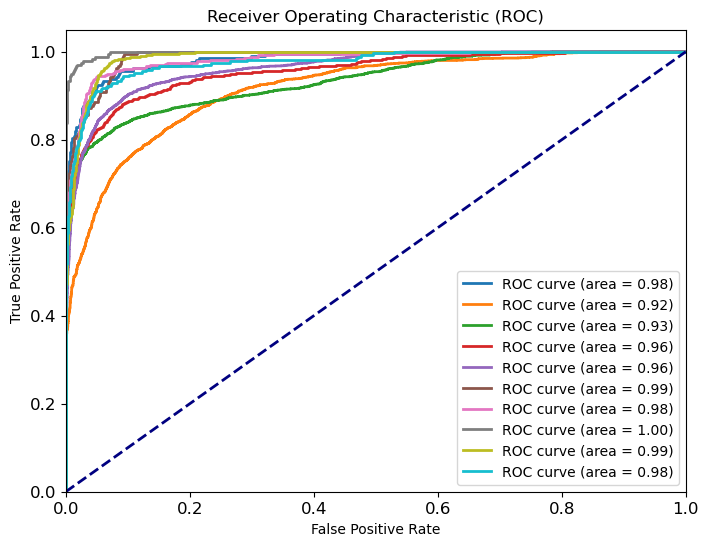

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

probabilities_dt_train = rf_tree_clf.predict_proba(x_train)
roc_auc_scores_dt_train = []

plt.figure(figsize=(8, 6))
unique_labels_dt_train = np.unique(y_train)

for i in range(len(unique_labels_dt_train)):
    fpr_dt_train, tpr_dt_train, _ = roc_curve((y_train == unique_labels_dt_train[i]).astype(int), probabilities_dt_train[:, i])
    roc_auc_dt_train = auc(fpr_dt_train, tpr_dt_train)
    roc_auc_scores_dt_train.append(roc_auc_dt_train)
    plt.plot(fpr_dt_train, tpr_dt_train, lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_dt_train))
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

## Cross Validation results for training dataset

In [29]:
cv_score_rf = cross_val_score(rf_tree_clf, x_train, y_train, cv=10, scoring='accuracy')

print(f'Cross Validation Scores: {cv_score_rf}')
print(f'Mean Accuracy: {cv_score_rf.mean()}')
print(f'Standard Deviation: {cv_score_rf.std()}')

Cross Validation Scores: [0.46439628 0.48503612 0.57688338 0.68317853 0.66150671 0.65944272
 0.3880289  0.6006192  0.70381837 0.64705882]
Mean Accuracy: 0.5869969040247678
Standard Deviation: 0.10129596958817277


# Finding Optimal Hyperparameters Using Randomized Search 

In [30]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats

# Define the parameter distributions to sample from
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': scipy.stats.randint(1, 100),
    'min_samples_split': scipy.stats.randint(2, 20),
    'min_samples_leaf': scipy.stats.randint(1, 10)
}

# Create the Decision Tree classifier
rf_clf = RandomForestClassifier(random_state=42)

# Perform Random Search with cross-validation
random_search = RandomizedSearchCV(rf_clf, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Fit the random search to your data
random_search.fit(x_train, y_train)

# Get the best hyperparameters and model
best_params = random_search.best_params_
best_rf_clf = random_search.best_estimator_
print("Best Parameters:", best_params)

Best Parameters: {'criterion': 'entropy', 'max_depth': 97, 'min_samples_leaf': 1, 'min_samples_split': 14}


# Tree 1 
## Classifier with best working parameters

In [31]:
best_rf_clf

RandomForestClassifier(criterion='entropy', max_depth=97, min_samples_split=14,
                       random_state=42)

### Accuracy for training dataset

In [32]:
y_rf_train = best_rf_clf.predict(x_train)
accu_rf_train = accuracy_score(y_train, y_rf_train)
print("Accuracy for training dataset:", accu_rf_train)

Accuracy for training dataset: 0.999484004127967


### Accuracy for testing dataset

In [33]:
y_rf_test = best_rf_clf.predict(x_test)
accu_rf_test = accuracy_score(y_test, y_rf_test)
print("Accuracy for training dataset:", accu_rf_test)

Accuracy for training dataset: 0.7851132686084142


# Tree 2
## Moving 30% of training instances into testing dataset

In [34]:
classifier_rf_30= RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5, n_estimators=100, oob_score=True)
classifier_rf_30.fit(x_train_3, y_train_3)


RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=42)

### Accuracy for training dataset

In [35]:
y_predict_train30 = classifier_rf_30.predict(x_train_3)

accuracy_30 = accuracy_score(y_train_3, y_predict_train30)
report_30 = classification_report(y_train_3, y_predict_train30, zero_division=1)

print(f'Accuracy: {accuracy_30}')
print(f'Classification Report:\n {report_30}')

Accuracy: 0.754828247088309
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       135
           1       0.71      0.81      0.76      1555
           2       0.73      0.81      0.77      1572
           3       0.70      0.82      0.76       984
           4       0.85      0.82      0.84      1393
           5       1.00      0.17      0.29       139
           6       0.86      0.60      0.70       260
           7       1.00      0.62      0.76       175
           8       0.74      0.64      0.69       382
           9       0.94      0.52      0.67       188

    accuracy                           0.75      6783
   macro avg       0.85      0.58      0.62      6783
weighted avg       0.77      0.75      0.74      6783



### Accuracy for testing dataset

In [36]:
y_predict_test30 = classifier_rf_30.predict(new_x_test_30)

accuracy_test30 = accuracy_score(new_y_test_30, y_predict_test30)
report_test30 = classification_report(new_y_test_30, y_predict_test30, zero_division=1)


print(f'Accuracy: {accuracy_test30}')
print(f'Classification Report:\n {report_test30}')

d:\Projects\anaconda\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.6659996664999166
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       135
           1       0.66      0.79      0.72      1385
           2       0.66      0.75      0.70      1428
           3       0.58      0.73      0.65       876
           4       0.77      0.69      0.73      1247
           5       1.00      0.08      0.15       131
           6       0.72      0.31      0.43       190
           7       1.00      0.28      0.44       125
           8       0.55      0.55      0.55       308
           9       0.88      0.38      0.53       172

    accuracy                           0.67      5997
   macro avg       0.78      0.46      0.49      5997
weighted avg       0.70      0.67      0.65      5997



# Tree 3
## Moving 60% of training instances into testing dataset

In [37]:
classifier_rf_60= RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5, n_estimators=100, oob_score=True)
classifier_rf_60.fit(x_train_6, y_train_6)

RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=42)

### Accuracy for training dataset

In [38]:
y_predict_train60 = classifier_rf_60.predict(x_train_6)

accuracy_60 = accuracy_score(y_train_6, y_predict_train60)
report_60 = classification_report(y_train_6, y_predict_train60, zero_division=1)

print(f'Accuracy: {accuracy_60}')
print(f'Classification Report:\n {report_60}')

Accuracy: 0.7739938080495357
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00        76
           1       0.71      0.85      0.77       884
           2       0.74      0.83      0.78       892
           3       0.73      0.82      0.77       544
           4       0.88      0.85      0.86       829
           5       1.00      0.17      0.29        81
           6       0.96      0.61      0.74       141
           7       1.00      0.50      0.67        96
           8       0.81      0.69      0.75       222
           9       0.93      0.56      0.70       111

    accuracy                           0.77      3876
   macro avg       0.88      0.59      0.63      3876
weighted avg       0.80      0.77      0.76      3876



### Accuracy for testing dataset

In [39]:
y_predict_test60 = classifier_rf_60.predict(new_x_test_60)

accuracy_test60 = accuracy_score(new_y_test_60, y_predict_test60)
report_test60 = classification_report(new_y_test_60, y_predict_test60, zero_division=1)

print(f'Accuracy: {accuracy_test60}')
print(f'Classification Report:\n {report_test60}')

d:\Projects\anaconda\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.6709344115004492
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       194
           1       0.65      0.79      0.71      2056
           2       0.63      0.73      0.67      2108
           3       0.63      0.71      0.67      1316
           4       0.77      0.74      0.76      1811
           5       1.00      0.10      0.17       189
           6       0.82      0.36      0.50       309
           7       1.00      0.19      0.32       204
           8       0.66      0.57      0.61       468
           9       0.85      0.42      0.56       249

    accuracy                           0.67      8904
   macro avg       0.80      0.46      0.50      8904
weighted avg       0.70      0.67      0.65      8904

